In [10]:
import numpy as np
import astropy.table as at
import jax.numpy as jnp

import loss      as wobble_loss
import simulator as wobble_sim
import model     as wobble_model
import dataset   as wobble_data
import matplotlib.pyplot as plt

In [11]:
import os.path as path
import os

import astropy.units as u
import astropy.constants as const

In [12]:
import h5py

In [13]:
filename = 'data/sim_full_hr100000_lr20000_s20_e5_sn10_tn10_gn10_y0.0-0.9_v30_ep0.0001_g1.0_w1.0.h5'
f = h5py.File(filename,'r+')
lamb = f['samples']['wavelength']
flux = f['samples']['flux']
ferr = f['samples']['flux_error']

lamb_theory = f['theory']['wavelength']
flux_stellar = f['theory']['flux_stellar']
flux_tellurics = f['theory']['flux_tellurics']
flux_gas = f['theory']['flux_gas']

In [14]:
mask = np.zeros(flux.shape,dtype=bool)

In [15]:
# size of grid search, and velocity +/- to extend in this search in km/s
vel_width          = 300 * u.km/u.s
vel_padding        = 300 * u.km/u.s
resolving_constant = 40000

In [16]:
lamb, flux, ferr, mask = np.array(lamb), np.array(flux), np.array(ferr), np.array(mask)

In [17]:
sigma = 80
flux       = wobble_data.interpolate_mask(flux,mask)
flux_norm  = wobble_data.normalize_flux(flux,sigma)

x, y, yerr = np.log(lamb), np.log(flux_norm), ferr/flux
y, yerr    = wobble_data.set_masked(y,yerr,mask)
epoches    = y.shape[0]

<ipython-input-17-09f70aa8a986>:5: RuntimeWarning: divide by zero encountered in log
  x, y, yerr = np.log(lamb), np.log(flux_norm), ferr/flux
<ipython-input-17-09f70aa8a986>:5: RuntimeWarning: invalid value encountered in true_divide
  x, y, yerr = np.log(lamb), np.log(flux_norm), ferr/flux


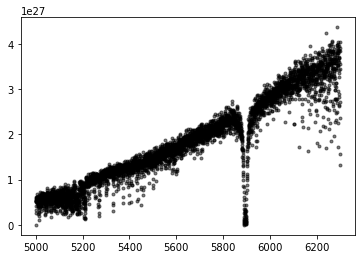

In [19]:
epoch_idx = 2
plt.errorbar(lamb,flux[epoch_idx,:],ferr[epoch_idx,:],fmt='.k',elinewidth=0.7,zorder=1,alpha=0.5,ms=6)
plt.show()

In [20]:
x_shifts  = np.array(f['constants']['delta'])
init_vels = wobble_data.velocityfromshift(x_shifts)

In [21]:
loss = wobble_loss.ChiSquare()

In [22]:
x = np.expand_dims(x,axis=0)
print(x.shape)
x = np.repeat(x,repeats=y.shape[0],axis=0)
print(x.shape)

(1, 4623)
(5, 4623)


In [23]:
x.shape

(5, 4623)

In [24]:
l = 0
r = 6000
x_grid = wobble_model.get_lin_spaced_grid(x[:,l:r],padding=wobble_data.shifts(vel_padding),step=wobble_data.shifts(const.c.to(u.km/u.s)/resolving_constant))
stellar_model = wobble_model.CompositeModel([wobble_model.ShiftingModel(x_shifts),wobble_model.JaxLinear(x_grid)])
stellar_model.fit(1)

In [25]:
maxiter = 128
res, callback = stellar_model.optimize(loss,x[:,l:r],y[:,l:r],yerr[:,l:r],maxiter)

In [26]:
outdir = 'out'
file_tail     = path.split(filename)[1][:-4]
model_name = path.join(outdir,'stellar_model{}_l{}_r{}_mI{}_chi_s{}_rs{}.pt'.format(file_tail,l,r,maxiter,vel_width.value,resolving_constant))
wobble_model.save(model_name,stellar_model)

In [27]:
import matplotlib.pyplot as plt

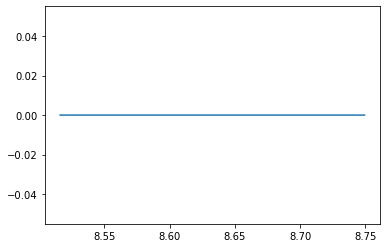

In [28]:
plt.plot(stellar_model[1].xs,stellar_model[1].p)

In [52]:
stellar_model[0].p

array([ 9.37722828e-05,  4.01188435e-05,  7.13323093e-05,  9.35418362e-05,
       -4.66829811e-05])

In [30]:
epoch_idx = 2
residuals = (y[epoch_idx,:] - stellar_model(stellar_model.get_parameters(),x[epoch_idx,:],i=epoch_idx)) / yerr[epoch_idx,:]

In [31]:
rms_chi = np.sqrt(np.mean(residuals ** 2))

/ext3/miniconda3/envs/wobbleenv/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


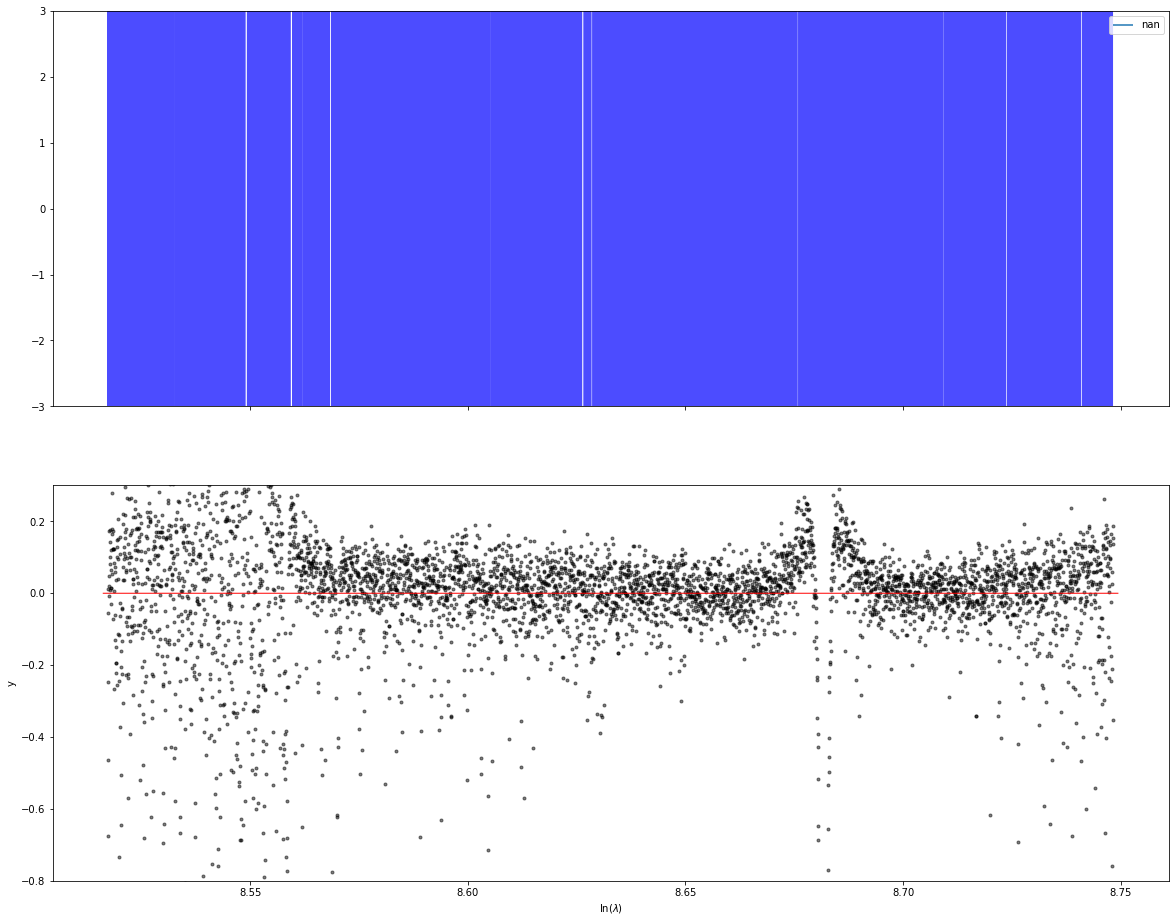

In [32]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(20,16),sharey=False,sharex=True)
ax[0].step(x[epoch_idx,:],residuals,where='mid',color='b',alpha=0.7)
hline_1 = ax[0].hlines(rms_chi,np.min(x[epoch_idx,:]),np.max(x[epoch_idx,:]))
ax[0].legend([hline_1],[rms_chi])
ax[0].set_ylim(-3,3)

ax[1].set_xlabel('ln($\lambda$)')
ax[1].set_ylabel('y')
ax[1].errorbar(x[epoch_idx,:],y[epoch_idx,:],yerr[epoch_idx,:],fmt='.k',elinewidth=0.7,zorder=1,alpha=0.5,ms=6)
ax[1].plot(stellar_model[1].xs+stellar_model[0].p[epoch_idx],stellar_model[1].p,'r',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
ax[1].set_ylim(-0.8,0.3)

# xmin = 9.72
# xmax = 9.74
# plt.xlim(xmin,xmax)
plt.show()

In [57]:
print(stellar_model.parameters_per_model)
stellar_model.fit(0)
print(stellar_model.parameters_per_model)

[   0. 9324.]
[   0. 9324.]


In [26]:
velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,const.c.to(u.km/u.s).value/resolving_constant)*u.km/u.s
velocity_grid = np.add.outer(init_vels,velocity_kern)

shift_grid    = wobble_data.shifts(velocity_grid)
loss_array    = wobble_data.get_loss_array(shift_grid,stellar_model[1],x[:,l:r],y[:,l:r],yerr[:,l:r],loss)
stacked = np.stack((shift_grid,loss_array))
# wobble_model.save(loss_name,stacked)
x_min   = wobble_data.get_parabolic_min(loss_array,shift_grid)
# wobble_model.save(x_name,x_min)

epch 0: min 33
epch 1: min 33
epch 2: min 33
epch 3: min 34
epch 4: min 45
epch 5: min 45
epch 6: min 45
epch 7: min 45
epch 8: min 43
epch 9: min 43
epch 10: min 43
epch 11: min 43
epch 12: min 33
epch 13: min 33
epch 14: min 33
epch 15: min 33
epch 16: min 49
epch 17: min 49
epch 18: min 49
epch 19: min 48
epch 20: min 49
epch 21: min 49
epch 22: min 49
epch 23: min 49
epch 24: min 33
epch 25: min 33
epch 26: min 33
epch 27: min 33
epch 28: min 42
epch 29: min 42
epch 30: min 42
epch 31: min 42
epch 32: min 33
epch 33: min 33
epch 34: min 33
epch 35: min 33


In [27]:
stellar_model[0].p = x_min
stellar_model[0].fit()

In [28]:
# stellar_model.fix_parameters(0)
# stellar_model[0].p
# stellar_model.p.shape
stellar_model.parameters_per_model

array([   0., 4531.])

In [29]:
maxiter = 128
res, callback = stellar_model.optimize(loss,x[:,l:r],y[:,l:r],yerr[:,l:r],maxiter)
outdir = 'out'
model_name = path.join(outdir,'stellar_model{}_l{}_r{}_mI{}_chi_s{}_rs{}.pt'.format(file_tail,l,r,maxiter,vel_width.value,resolving_constant))
wobble_model.save(model_name,stellar_model)

207710.58
203548.3
202218.9
201844.6
201653.66
201567.58
201496.7
201481.6
201431.98
201420.95
201404.58
201387.12
201385.33
201370.03
201366.78
201359.64
201355.58
201349.2
201346.08
201343.17
201339.72
201336.86
201335.17
201333.3
201332.11
201330.69
201328.94
201328.03
201326.89
201325.48
201324.84
201323.84
201322.9
201321.89
201320.55
201319.56
201318.7
201318.05
201317.33
201316.84
201315.55
201315.12
201314.44
201313.56
201312.84
201312.33
201311.75
201311.39
201310.77
201310.33
201309.84
201309.58
201309.16
201308.92
201308.66
201308.36
201308.14
201307.75
201307.36
201307.14
201306.84
201306.7
201306.44
201306.08
201305.89
201305.52
201305.23
201305.08
201304.88
201304.75
201304.53
201304.34
201304.12
201303.89
201303.69
201303.44
201303.11
201302.94
201302.69
201302.36
201302.16
201301.92
201301.66
201301.45
201301.22
201300.97
201300.81
201300.64
201300.48
201300.23
201300.08
201299.95
201299.8
201299.66
201299.48
201299.34
201299.16
201299.03
201298.89
201298.72
201298.64
2

In [30]:
res

      fun: array(201294.40625)
 hess_inv: <4567x4567 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 130
      nit: 128
     njev: 130
   status: 1
  success: False
        x: array([-3.57330919e-06, -3.52489155e-06, -1.65825418e-06, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [31]:
# print('results ', res.jac[:68])
print('deltas ',stellar_model[0].p)
print(np.equal(stellar_model[0].p,res.x[:36]))

deltas  [-3.57330919e-06 -3.52489155e-06 -1.65825418e-06 -2.66884371e-07
 -1.21788048e-07 -3.15251441e-06 -7.19477271e-07 -6.54052428e-07
  3.48839853e-06  3.29571048e-06  1.21750566e-06  4.11715291e-06
  1.19835931e-06  3.27968564e-06  2.87251123e-06  3.72861996e-06
  2.25317785e-06  5.43282522e-06  3.95757752e-06 -2.14367333e-06
 -5.65129994e-07 -2.46370428e-06 -3.12898010e-06 -2.75337902e-06
 -8.36172148e-07  9.97135771e-07 -1.37780717e-06 -7.65899642e-07
 -9.02630859e-08  4.76295014e-07  1.97170357e-06  3.61172852e-06
 -8.95621326e-07 -3.09402299e-06 -1.35917287e-06 -4.18316358e-06]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


In [32]:
import astropy.coordinates as coord
import astropy.time as time

In [33]:
hatp20_c = coord.SkyCoord.from_name(star_name)
loc      = coord.EarthLocation.of_site(obs_name)
ts       = time.Time(tbl['BJD'], format='jd', scale='tdb')
bc       = hatp20_c.radial_velocity_correction(obstime=ts, location=loc).to(u.m/u.s)

In [34]:
shifts = stellar_model[0].p
dates = time.Time(tbl['BJD']-tbl['BJD'].min(),format='jd',scale='tdb')

In [35]:
velocities = wobble_data.velocityfromshift(shifts)

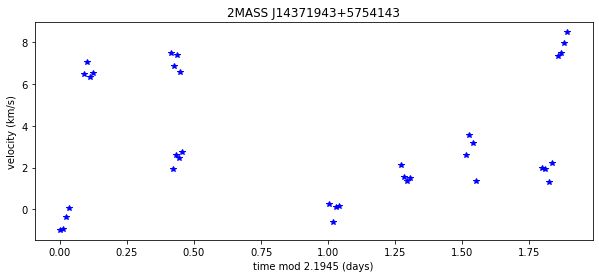

In [40]:
period = 2.1945
plt.figure(figsize=(10,4))
plt.plot(dates.value % period,velocities.to(u.km/u.s).value - bc.to(u.km/u.s).value,'*b')
plt.xlabel('time mod {} (days)'.format(period))
plt.ylabel('velocity (km/s)')
plt.title(star_name)
plt.show()

In [41]:
res

      fun: array(201294.40625)
 hess_inv: <4567x4567 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 130
      nit: 128
     njev: 130
   status: 1
  success: False
        x: array([-3.57330919e-06, -3.52489155e-06, -1.65825418e-06, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [42]:
stellar_model[0].p.shape

(36,)

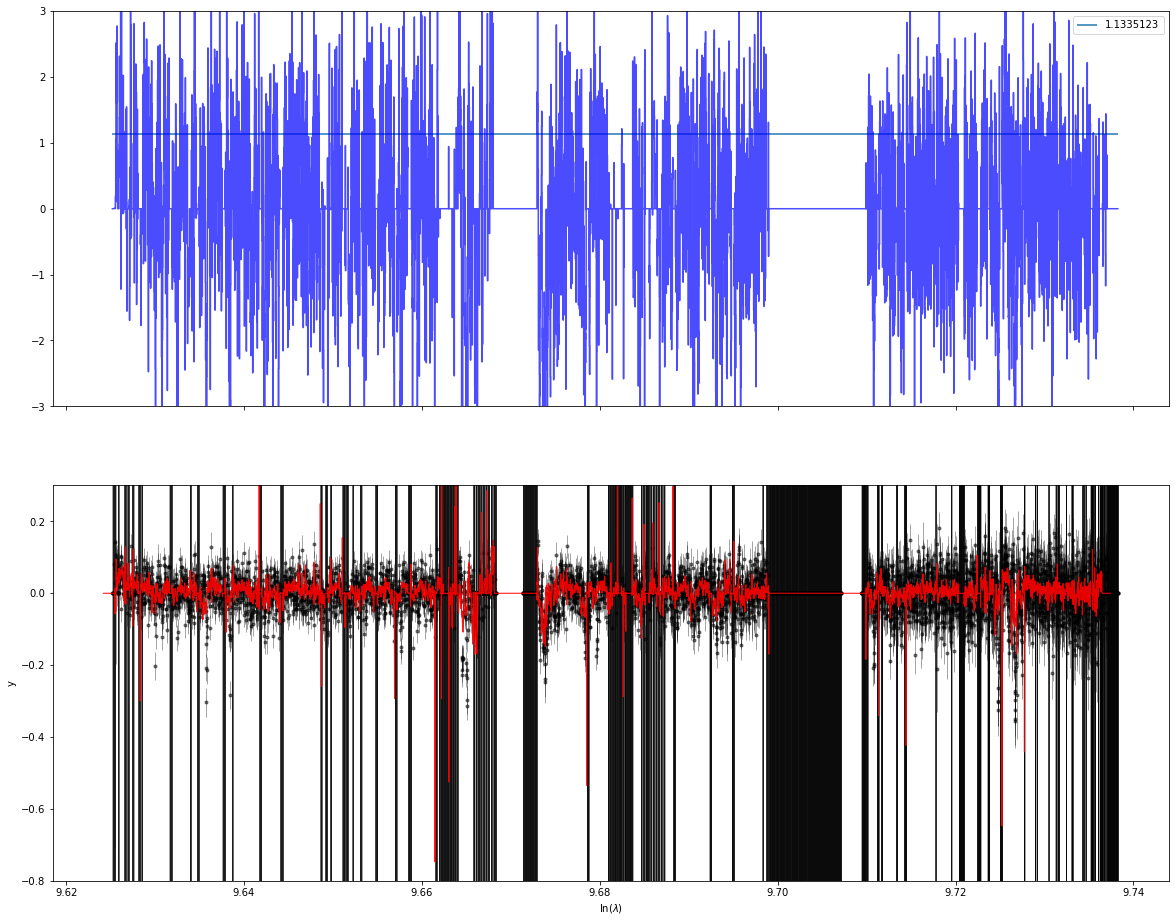

In [43]:
epoch_idx = 23
residuals = (y[epoch_idx,:] - stellar_model(stellar_model.get_parameters(),x[epoch_idx,:],i=epoch_idx)) / yerr[epoch_idx,:]
rms_chi = np.sqrt(np.mean(residuals ** 2))
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(20,16),sharey=False,sharex=True)
ax[0].step(x[epoch_idx,:],residuals,where='mid',color='b',alpha=0.7)
hline_1 = ax[0].hlines(rms_chi,np.min(x[epoch_idx,:]),np.max(x[epoch_idx,:]))
ax[0].legend([hline_1],[rms_chi])
ax[0].set_ylim(-3,3)

ax[1].set_xlabel('ln($\lambda$)')
ax[1].set_ylabel('y')
ax[1].errorbar(x[epoch_idx,:],y[epoch_idx,:],yerr[epoch_idx,:],fmt='.k',elinewidth=0.7,zorder=1,alpha=0.5,ms=6)
ax[1].plot(stellar_model[1].xs+stellar_model[0].p[epoch_idx],stellar_model[1].p,'r',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
ax[1].set_ylim(-0.8,0.3)

# xmin = 9.72
# xmax = 9.74
# plt.xlim(xmin,xmax)
plt.show()